# Sleep Prediction - Unlocking the Secrets of Restful Nights
## In this problem we have to predict the sleep time. 

We have 8 years of historic health data taken from various devices including: Fitbit, Apple Watch and iPhone. <br>
This valuable data encompassed crucial metrics including step count, heart rate, exercise time, and energy burned.

### In this project we will train 2 model
1. Neural Network
2. Ensemble Model (Tree Based)
    1. Decision Tree
    2. Rnadom Forest
    2. ADA Boost
    3. Gradient Boost
    4. XGBoost
    
**So Let's get started with our eyes wide open Or..!!**
<!-- ![Sleep Gif](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Sleepingcatwhiskertwitches.gif/640px-Sleepingcatwhiskertwitches.gif "Sleep") -->
<!-- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Sleepingcatwhiskertwitches.gif/640px-Sleepingcatwhiskertwitches.gif" alt="Cat GIF" width="400" height="400">
 -->
<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNTQ3YWZhOTI3ODNkOGE1ZGFjNzRlYjQzMTlhNDc3NzA4ZWQwOGRmYSZlcD12MV9pbnRlcm5hbF9naWZzX2dpZklkJmN0PWc/vMbC8xqhIf9ny/giphy.gif" alt="Cat GIF" width="400" height="400">


In [1]:
# Check CUDA
!nvidia-smi

Fri May 26 09:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tqdm.notebook import tqdm

import os
import re
import sys

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
HOME = '/kaggle/working/'
HOMEDATA = '/kaggle/input/kaggle-pog-series-s01e04/'

# Load Training Data

In [4]:
train = pd.read_csv(f'{HOMEDATA}train.csv', parse_dates=['date'], index_col='date')
train.head()

,sleep_hours
date,
2015-02-19,6.400000
2015-02-20,7.583333
2015-02-21,6.350000
2015-02-22,6.500000
2015-02-23,8.916667


In [5]:
train.tail()

,sleep_hours
date,
2021-12-25,7.933333
2021-12-26,3.850000
2021-12-29,6.175000
2021-12-30,5.158333
2021-12-31,5.908333


In [6]:
train.shape

(2354, 1)

# Load Testing Data

In [6]:
test = pd.read_csv(f'{HOMEDATA}test.csv', parse_dates=['date'], index_col='date')
test.index.min(), test.index.max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-03-16 00:00:00'))

# Feature Extraction from XML file

In [7]:
#### https://github.com/markwk/qs_ledger/blob/master/apple_health/apple-health-data-parser.py
from xml.etree import ElementTree
from collections import Counter, OrderedDict

__version__ = '1.3'

RECORD_FIELDS = OrderedDict((
    ('sourceName', 's'),
    ('sourceVersion', 's'),
    ('device', 's'),
    ('type', 's'),
    ('unit', 's'),
    ('creationDate', 'd'),
    ('startDate', 'd'),
    ('endDate', 'd'),
    ('value', 'n'),
))

ACTIVITY_SUMMARY_FIELDS = OrderedDict((
    ('dateComponents', 'd'),
    ('activeEnergyBurned', 'n'),
    ('activeEnergyBurnedGoal', 'n'),
    ('activeEnergyBurnedUnit', 's'),
    ('appleExerciseTime', 's'),
    ('appleExerciseTimeGoal', 's'),
    ('appleStandHours', 'n'),
    ('appleStandHoursGoal', 'n'),
))

WORKOUT_FIELDS = OrderedDict((
    ('sourceName', 's'),
    ('sourceVersion', 's'),
    ('device', 's'),
    ('creationDate', 'd'),
    ('startDate', 'd'),
    ('endDate', 'd'),
    ('workoutActivityType', 's'),
    ('duration', 'n'),
    ('durationUnit', 's'),
    ('totalDistance', 'n'),
    ('totalDistanceUnit', 's'),
    ('totalEnergyBurned', 'n'),
    ('totalEnergyBurnedUnit', 's'),
))

FIELDS = {
    'Record': RECORD_FIELDS,
    'ActivitySummary': ACTIVITY_SUMMARY_FIELDS,
    'Workout': WORKOUT_FIELDS,
}


PREFIX_RE = re.compile('^HK.*TypeIdentifier(.+)$')
ABBREVIATE = True
VERBOSE = True

def format_freqs(counter):
    """
    Format a counter object for display.
    """
    return '\n'.join( '%s: %d' % (tag, counter[tag]) for tag in sorted(counter.keys()) )


def format_value(value, datatype):
    """
    Format a value for a CSV file, escaping double quotes and backslashes.
    None maps to empty.
    datatype should be
        's' for string (escaped)
        'n' for number
        'd' for datetime
    """
    if value is None:
        return ''
    elif datatype == 's':  # string
        return '"%s"' % value.replace('\\', '\\\\').replace('"', '\\"')
    elif datatype in ('n', 'd'):  # number or date
        return value
    else:
        raise KeyError('Unexpected format value: %s' % datatype)


def abbreviate(s, enabled=ABBREVIATE):
    """
    Abbreviate particularly verbose strings based on a regular expression
    """
    m = re.match(PREFIX_RE, s)
    return m.group(1) if enabled and m else s


class HealthDataExtractor(object):
    """
    Extract health data from Apple Health App's XML export, export.xml.
    Inputs:
        path:      Relative or absolute path to export.xml
        verbose:   Set to False for less verbose output
    Outputs:
        Writes a CSV file for each record type found, in the same
        directory as the input export.xml. Reports each file written
        unless verbose has been set to False.
    """
    def __init__(self, path, dest_path, verbose=VERBOSE):
        self.in_path = path
        self.verbose = verbose
        self.directory = os.path.abspath(os.path.split(path)[0])
        self.dest = dest_path
        # create the directory and its parent directories if they don't exist
        os.makedirs(dest_path, exist_ok=True)
        with open(path) as f:
            self.report('Reading data from %s . . . ' % path, end='')
            self.data = ElementTree.parse(f)
            self.report('done')
        self.root = self.data._root
        self.nodes = list(self.root)
        self.n_nodes = len(self.nodes)
        self.abbreviate_types()
        self.collect_stats()

    def report(self, msg, end='\n'):
        if self.verbose:
            print(msg, end=end)
            sys.stdout.flush()

    def count_tags_and_fields(self):
        self.tags = Counter()
        self.fields = Counter()
        for record in self.nodes:
            self.tags[record.tag] += 1
            for k in record.keys():
                self.fields[k] += 1

    def count_record_types(self):
        """
        Counts occurrences of each type of (conceptual) "record" in the data.
        In the case of nodes of type 'Record', this counts the number of
        occurrences of each 'type' or record in self.record_types.
        In the case of nodes of type 'ActivitySummary' and 'Workout',
        it just counts those in self.other_types.
        The slightly different handling reflects the fact that 'Record'
        nodes come in a variety of different subtypes that we want to write
        to different data files, whereas (for now) we are going to write
        all Workout entries to a single file, and all ActivitySummary
        entries to another single file.
        """
        self.record_types = Counter()
        self.other_types = Counter()
        for record in self.nodes:
            if record.tag == 'Record':
                self.record_types[record.attrib['type']] += 1
            elif record.tag in ('ActivitySummary', 'Workout'):
                self.other_types[record.tag] += 1
            elif record.tag in ('Export', 'Me'):
                pass
            else:
                self.report('Unexpected node of type %s.' % record.tag)

    def collect_stats(self):
        self.count_record_types()
        self.count_tags_and_fields()

    def open_for_writing(self):
        self.handles = {}
        self.paths = []
        for kind in (list(self.record_types) + list(self.other_types)):
            path = os.path.join(self.dest, '%s.csv' % abbreviate(kind))
            f = open(path, 'w')
            headerType = (kind if kind in ('Workout', 'ActivitySummary')
                               else 'Record')
            f.write(','.join(FIELDS[headerType].keys()) + '\n')
            self.handles[kind] = f
            self.report('Opening %s for writing' % path)

    def abbreviate_types(self):
        """
        Shorten types by removing common boilerplate text.
        """
        for node in self.nodes:
            if node.tag == 'Record':
                if 'type' in node.attrib:
                    node.attrib['type'] = abbreviate(node.attrib['type'])

    def write_records(self):
        kinds = FIELDS.keys()
        for node in self.nodes:
            if node.tag in kinds:
                attributes = node.attrib
                kind = attributes['type'] if node.tag == 'Record' else node.tag
                values = [format_value(attributes.get(field), datatype)
                          for (field, datatype) in FIELDS[node.tag].items()]
                line = ','.join(values) + '\n'
                self.handles[kind].write(line)

    def close_files(self):
        for (kind, f) in self.handles.items():
            f.close()
            self.report('Written %s data.' % abbreviate(kind))

    def extract(self):
        self.open_for_writing()
        self.write_records()
        self.close_files()

    def report_stats(self):
        print('\nTags:\n%s\n' % format_freqs(self.tags))
        print('Fields:\n%s\n' % format_freqs(self.fields))
        print('Record types:\n%s\n' % format_freqs(self.record_types))


data = HealthDataExtractor(path=f'{HOMEDATA}raw_health_export.xml', dest_path=f'{HOME}parsedXML/')
data.report_stats()
data.extract();

Reading data from /kaggle/input/kaggle-pog-series-s01e04/raw_health_export.xml . . . done
Unexpected node of type ExportDate.

Tags:
ActivitySummary: 900
ExportDate: 1
Me: 1
Record: 2795078
Workout: 1387

Fields:
HKCharacteristicTypeIdentifierBiologicalSex: 1
HKCharacteristicTypeIdentifierBloodType: 1
HKCharacteristicTypeIdentifierCardioFitnessMedicationsUse: 1
HKCharacteristicTypeIdentifierDateOfBirth: 1
HKCharacteristicTypeIdentifierFitzpatrickSkinType: 1
activeEnergyBurned: 900
activeEnergyBurnedGoal: 900
activeEnergyBurnedUnit: 900
appleExerciseTime: 900
appleExerciseTimeGoal: 900
appleMoveTime: 900
appleMoveTimeGoal: 900
appleStandHours: 900
appleStandHoursGoal: 900
creationDate: 2796465
dateComponents: 900
device: 2583875
duration: 1387
durationUnit: 1387
endDate: 2796465
sourceName: 2796465
sourceVersion: 2696886
startDate: 2796465
type: 2795078
unit: 2770121
value: 2794900
workoutActivityType: 1387

Record types:
ActiveEnergyBurned: 853486
AppleExerciseTime: 73715
AppleStandHou

In [8]:
HOMEXML = f'{HOME}/parsedXML/'

### XML file analysis

In [ ]:
# Useful files and their aggregating methods
useful_files = [
    'StepCount.csv',
    'HeartRate.csv',
    'DistanceWalkingRunning.csv',
    'BasalEnergyBurned.csv',
    'FlightsClimbed.csv',
    'ActiveEnergyBurned.csv'
    'Workout.csv',
    'BodyMass.csv'
]

In [35]:
file = 'StepCount.csv'
StepCount_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
StepCount_df = StepCount_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(StepCount_df.tail(1))
StepCount_df.head()

                       startDate  value
249129 2023-03-17 23:37:24-04:00     20


,startDate,value
0,2015-02-18 01:00:00-04:00,44
1,2015-02-19 01:00:00-04:00,2669
2,2015-02-20 01:00:00-04:00,14552
3,2015-02-21 01:00:00-04:00,7769
4,2015-02-22 01:00:00-04:00,16675


In [36]:
file = 'HeartRate.csv'
HeartRate_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
HeartRate_df = HeartRate_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(HeartRate_df.tail(1))
HeartRate_df.head()

                       startDate  value
411633 2023-03-18 00:06:35-04:00   70.0


,startDate,value
0,2015-04-20 18:16:21-04:00,89.0
1,2015-04-20 18:16:22-04:00,88.0
2,2015-04-20 18:16:23-04:00,88.0
3,2015-04-20 18:16:24-04:00,87.0
4,2015-04-20 18:16:25-04:00,86.0


In [37]:
HeartRate_df.tail()

,startDate,value
411629,2023-03-17 23:51:11-04:00,70.0000
411630,2023-03-17 23:54:22-04:00,70.4721
411631,2023-03-17 23:54:53-04:00,72.0000
411632,2023-03-18 00:01:03-04:00,69.0000
411633,2023-03-18 00:06:35-04:00,70.0000


**<font color='Green'>Inference:</font> Exercise Heart Rate - Exercise time starts at around 17:30 and ends at around 18:45  -- ~1:30 hours daily Exercise time**

In [38]:
file = 'DistanceWalkingRunning.csv'
DistanceWalkingRunning_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
DistanceWalkingRunning_df = DistanceWalkingRunning_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(DistanceWalkingRunning_df.tail(1))
DistanceWalkingRunning_df.head()

                       startDate     value
291023 2023-03-17 23:37:24-04:00  0.010562


,startDate,value
0,2015-02-18 01:00:00-04:00,0.019188
1,2015-02-19 01:00:00-04:00,1.311870
2,2015-02-20 01:00:00-04:00,7.167910
3,2015-02-21 01:00:00-04:00,3.823910
4,2015-02-22 01:00:00-04:00,8.195990


In [39]:
file = 'BasalEnergyBurned.csv'
BasalEnergyBurned_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
BasalEnergyBurned_df = BasalEnergyBurned_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(BasalEnergyBurned_df.tail(1))
BasalEnergyBurned_df.head()

                       startDate  value
297837 2023-03-17 23:46:36-04:00  26.23


,startDate,value
0,2012-04-20 00:00:00-04:00,1913.0
1,2012-04-21 00:00:00-04:00,1913.0
2,2012-04-22 00:00:00-04:00,1913.0
3,2012-04-23 00:00:00-04:00,1913.0
4,2012-04-24 00:00:00-04:00,1913.0


In [40]:
file = 'FlightsClimbed.csv'
FlightsClimbed_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
FlightsClimbed_df = FlightsClimbed_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(FlightsClimbed_df.tail(1))
FlightsClimbed_df.head()

                      startDate  value
44124 2023-03-17 22:43:37-04:00      1


,startDate,value
0,2015-04-19 09:08:15-04:00,1
1,2015-04-19 10:27:20-04:00,1
2,2015-04-19 10:31:38-04:00,1
3,2015-04-19 10:34:51-04:00,1
4,2015-04-19 11:40:34-04:00,1


In [41]:
file = 'ActiveEnergyBurned.csv'
ActiveEnergyBurned_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
ActiveEnergyBurned_df = ActiveEnergyBurned_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(ActiveEnergyBurned_df.tail(1))
ActiveEnergyBurned_df.head()

                       startDate  value
853485 2023-03-18 00:09:49-04:00  0.564


,startDate,value
0,2015-02-19 01:00:00-04:00,487.0
1,2015-02-20 01:00:00-04:00,1789.0
2,2015-02-21 01:00:00-04:00,1185.0
3,2015-02-22 01:00:00-04:00,2173.0
4,2015-02-23 01:00:00-04:00,903.0


In [42]:
# you can even check the heart rate data and will see the time interval
file = 'Workout.csv'
Workout_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','duration'], parse_dates=['startDate'])
Workout_df = Workout_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(Workout_df.tail(1))
Workout_df.head()

                     startDate   duration
1386 2023-03-17 19:00:04-04:00  34.016667


,startDate,duration
0,2015-04-20 18:16:21-04:00,55.450000
1,2015-04-20 19:11:57-04:00,27.783333
2,2015-04-21 21:11:44-04:00,59.750000
3,2015-04-22 17:29:49-04:00,54.666667
4,2015-04-22 18:28:54-04:00,14.883333


In [43]:
# you can even check the heart rate data and will see the time interval
file = 'BodyMass.csv'
BodyMass_df = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'], parse_dates=['startDate'])
BodyMass_df = BodyMass_df.sort_values('startDate').reset_index(drop=True)
# data[((data['startDate'].str.startswith('2015-04-20')) | (data['startDate'].str.startswith('2015-04-21')))]
print(BodyMass_df.tail(1))
BodyMass_df.head()

                     startDate  value
3746 2023-03-13 19:02:00-04:00  201.8


,startDate,value
0,2012-04-20 00:00:00-04:00,188.799
1,2012-04-21 00:00:00-04:00,188.799
2,2012-04-22 00:00:00-04:00,188.799
3,2012-04-23 00:00:00-04:00,188.799
4,2012-04-24 00:00:00-04:00,188.799


### PLot XML data

In [44]:
# fig, axs = plt.subplots(3, 3, figsize=(20,10))
# axs = axs.flatten()
# for i in tqdm(range(len(useful_files))):
#     sns.histplot(useful_files_dfs[i], ax=axs[i])
#     axs[i].title(useful_files[i])
# plt.tight_layout()
# plt.show()

# Include XML files with train

In [9]:
# Useful files and their aggregating methods
useful_files = {'StepCount.csv': 'sum',
                'HeartRate.csv': 'max',
                'DistanceWalkingRunning.csv': None, #--special treatment
                'BasalEnergyBurned.csv': 'sum',
                #'FlightsClimbed.csv',         #-- not seem fit
                'ActiveEnergyBurned.csv': 'sum',
                'Workout.csv': 'sum',
                'BodyMass.csv': 'max'}

In [10]:
def xml_data (data):
    temp = data.copy()
    for file in useful_files.keys():
        # Load file
        date_columns = ['startDate']
        if(file == 'Workout.csv'):
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','duration'])
            data.rename(columns = {'duration':'value'}, inplace=True)
        else: 
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'])
        data = data.sort_values('startDate').reset_index(drop=True)
        
        # Parse & Format the date
        for col in date_columns:
            data[col] = pd.to_datetime(data[col]).dt.tz_convert(None) #remove the UTC component, -0400
            data[col] = pd.to_datetime(data[col].apply(lambda x:x.strftime('%Y-%m-%d')))
    
        # Pre-process data 
        if file != 'DistanceWalkingRunning.csv':
            data = data.groupby('startDate').aggregate({'value': useful_files[file]})
        else:
            # Computation method for DistanceWalkingRunning
            dates = data['startDate'].unique()
            data_dict = {}
            for i, date in enumerate(dates):
                temp_dist = data[data['startDate'] == date]
                if max(temp_dist['value'].values) > 1:
                    data_dict[i] = (date, max(temp_dist['value'].values))
                else:
                    data_dict[i] = (date, sum(temp_dist['value'].values))
            data = pd.DataFrame(data_dict).T
            data.columns = ['startDate', 'value']
            data['value'] = data['value'].astype(float)
            data['startDate'] = pd.to_datetime(data['startDate'])
            data.set_index('startDate', inplace=True)
        
        # Merge with df
        trail = pd.merge(temp, data, how='inner', left_index = True, right_index = True)
        temp[file.split('.')[0]] = trail['value']
    return temp

In [11]:
train_xml = xml_data(train)
train_xml.head()

,sleep_hours,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,,
2015-02-19,6.400000,2669,NaN,1.31187,1898.0,487.0,NaN,188.799
2015-02-20,7.583333,14552,NaN,7.16791,1898.0,1789.0,NaN,188.799
2015-02-21,6.350000,7769,NaN,3.82391,1898.0,1185.0,NaN,188.799
2015-02-22,6.500000,16675,NaN,8.19599,1898.0,2173.0,NaN,188.799
2015-02-23,8.916667,6076,NaN,2.98648,1898.0,903.0,NaN,188.799


### Impute Nan values of XML file

In [12]:
def xml_impute (data):
    temp = data.copy()
    print('Pre-Imputation\n', temp.isna().sum())
    temp.loc[((~pd.isnull(temp['Workout'])) & (pd.isnull(temp['HeartRate']))), 'HeartRate'] = \
            temp.loc[~pd.isnull(temp['Workout']), 'HeartRate'].mean()
    temp.loc[pd.isnull(temp['HeartRate']), 'HeartRate'] = 110
    temp['BasalEnergyBurned'] = temp['BasalEnergyBurned'].fillna(method='bfill')
    temp['BodyMass'] = temp['BodyMass'].fillna(method='ffill')
    temp.loc[pd.isnull(temp['Workout']), 'Workout'] = 0
    
    dates_na = temp[pd.isnull(temp['ActiveEnergyBurned'])].index
    # ActiveEnergyBurned - previous 7 days average
    for date in dates_na:
        impute_val = temp[((temp.index >= date - pd.DateOffset(days=7)) & \
                                    (temp.index < date))]['ActiveEnergyBurned']
        temp.loc[(temp.index == date), 'ActiveEnergyBurned'] = impute_val.mean()
    print('Post-Imputation\n', temp.isna().sum())
    return temp

In [13]:
train_impute = xml_impute(train_xml)
train_impute.head()

Pre-Imputation
 sleep_hours                  0
StepCount                    0
HeartRate                 1897
DistanceWalkingRunning       0
BasalEnergyBurned            1
ActiveEnergyBurned        1302
Workout                   1803
BodyMass                   197
dtype: int64
Post-Imputation
 sleep_hours               0
StepCount                 0
HeartRate                 0
DistanceWalkingRunning    0
BasalEnergyBurned         0
ActiveEnergyBurned        0
Workout                   0
BodyMass                  0
dtype: int64


,sleep_hours,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,,
2015-02-19,6.400000,2669,110.0,1.31187,1898.0,487.0,0.0,188.799
2015-02-20,7.583333,14552,110.0,7.16791,1898.0,1789.0,0.0,188.799
2015-02-21,6.350000,7769,110.0,3.82391,1898.0,1185.0,0.0,188.799
2015-02-22,6.500000,16675,110.0,8.19599,1898.0,2173.0,0.0,188.799
2015-02-23,8.916667,6076,110.0,2.98648,1898.0,903.0,0.0,188.799


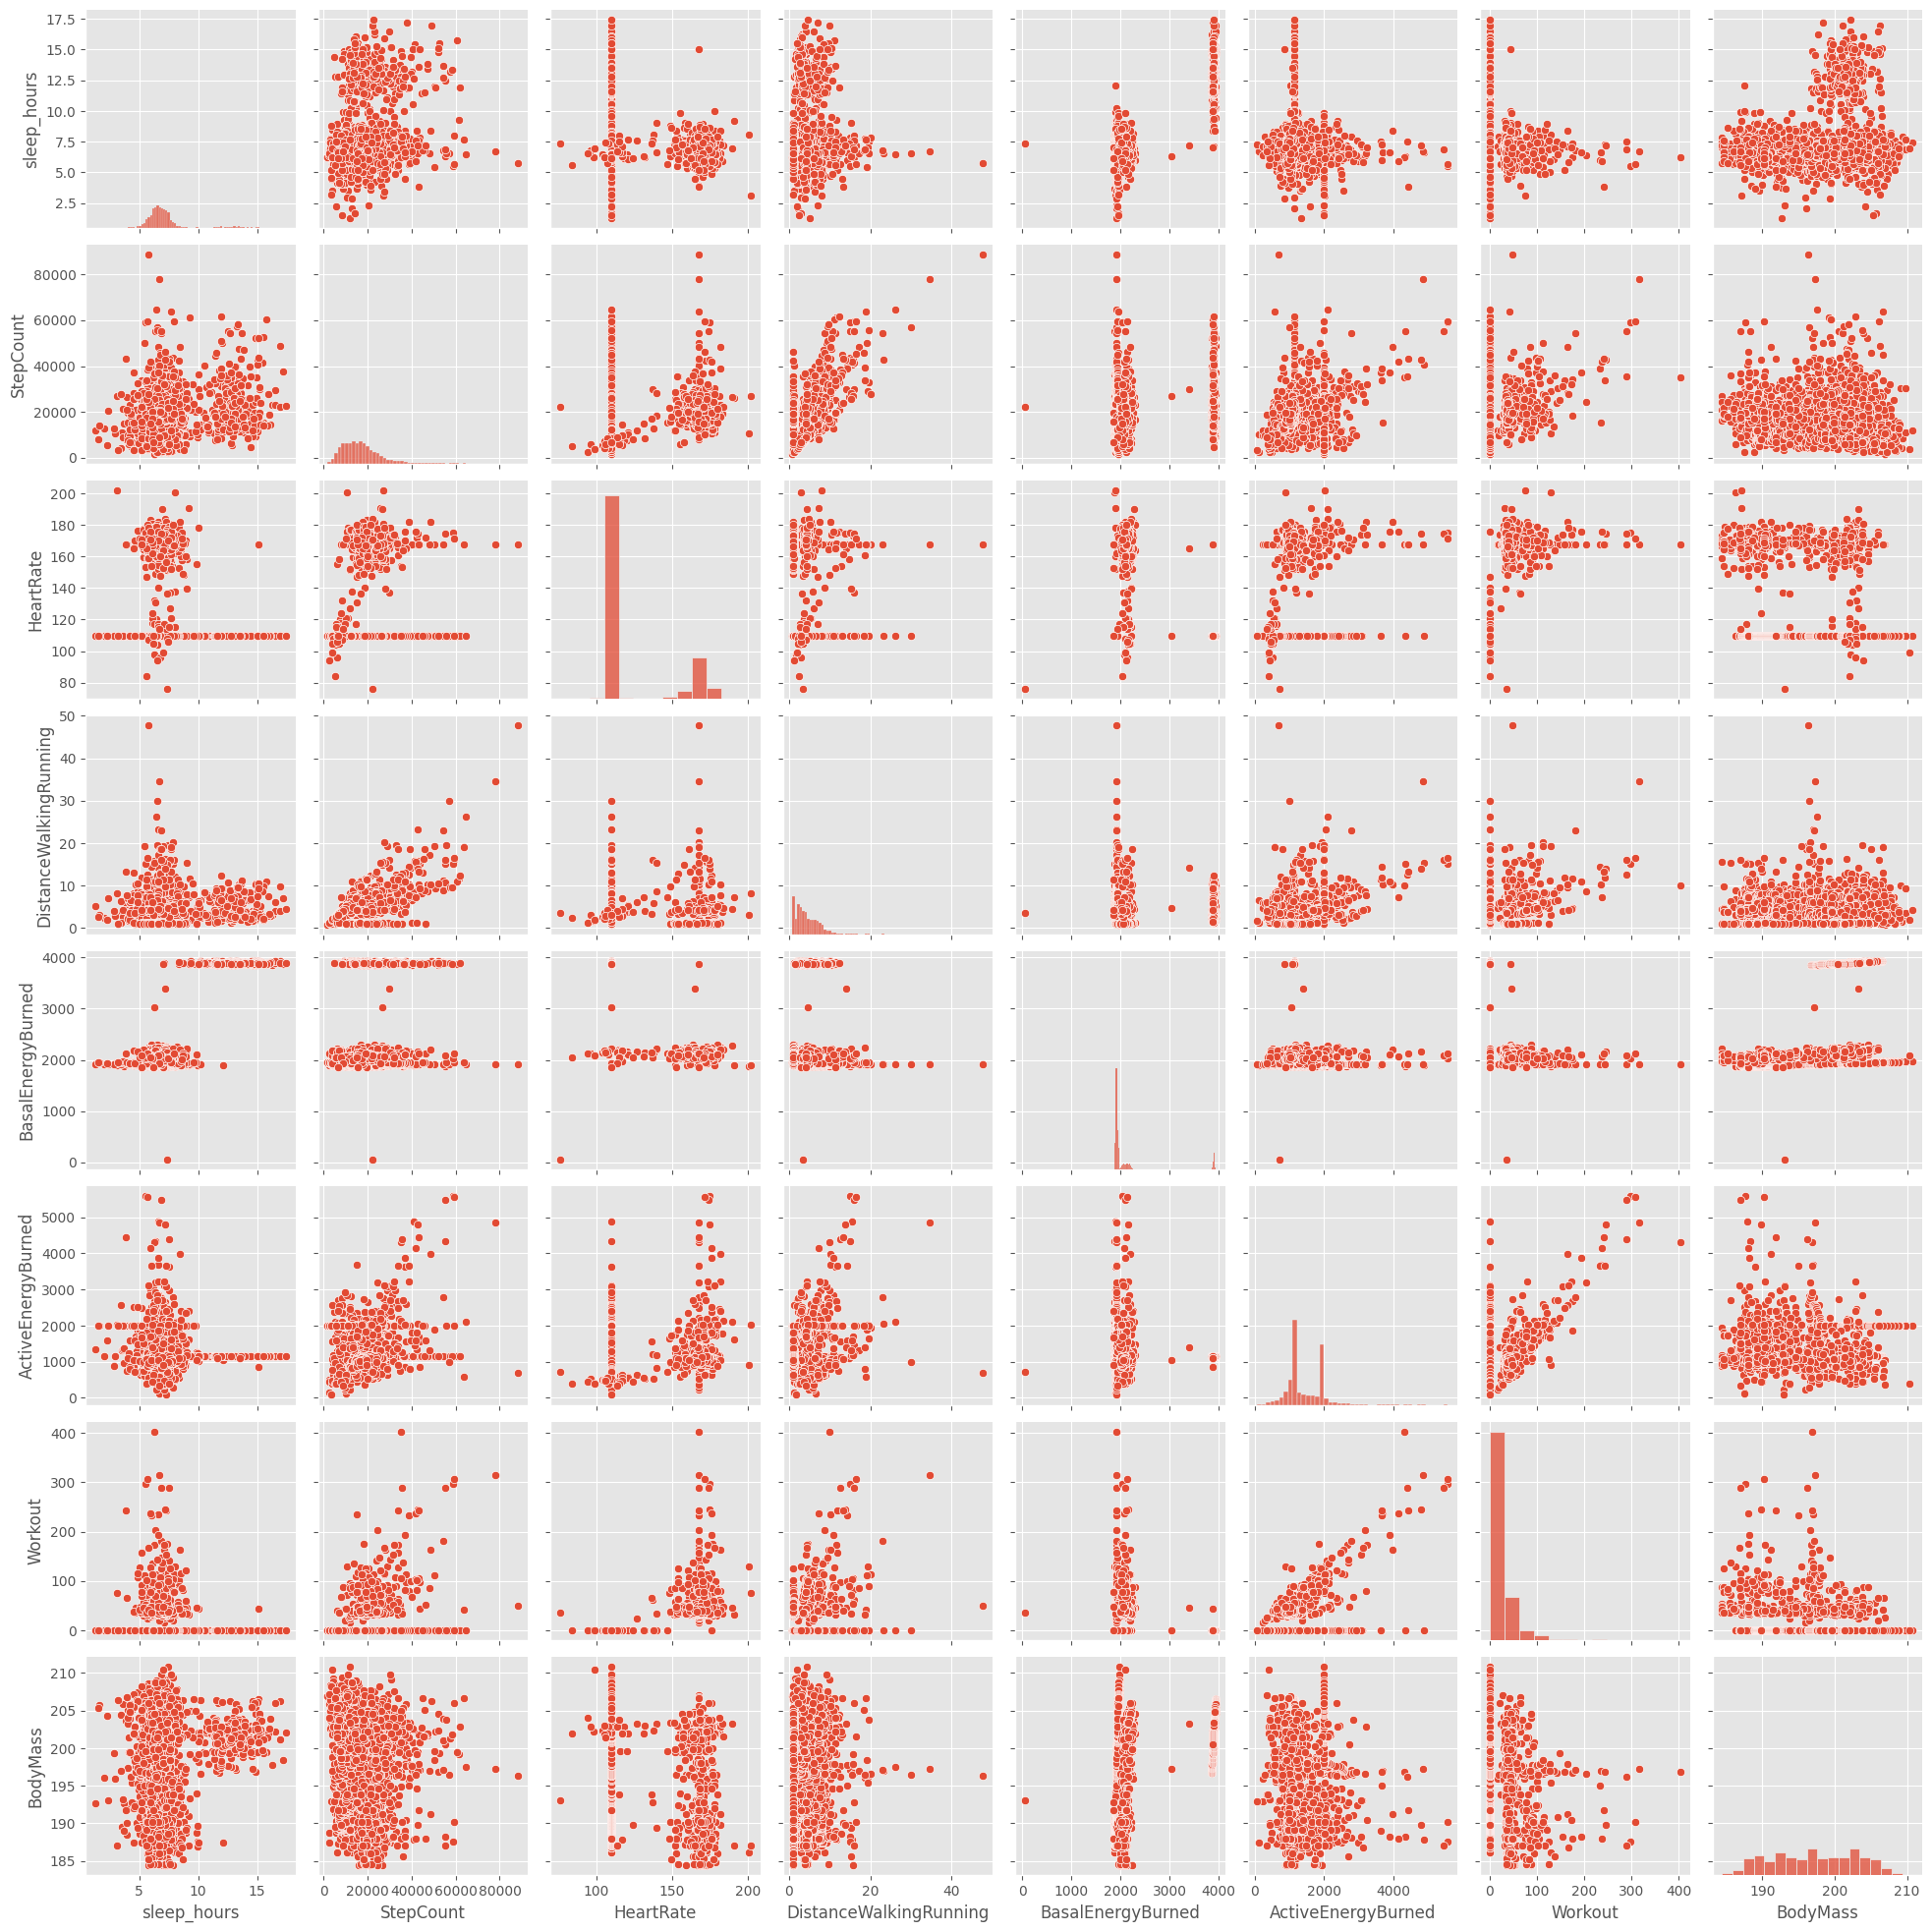

In [14]:
plot = sns.pairplot(train_impute)
# plot.savefig('plot.png')
plt.show()

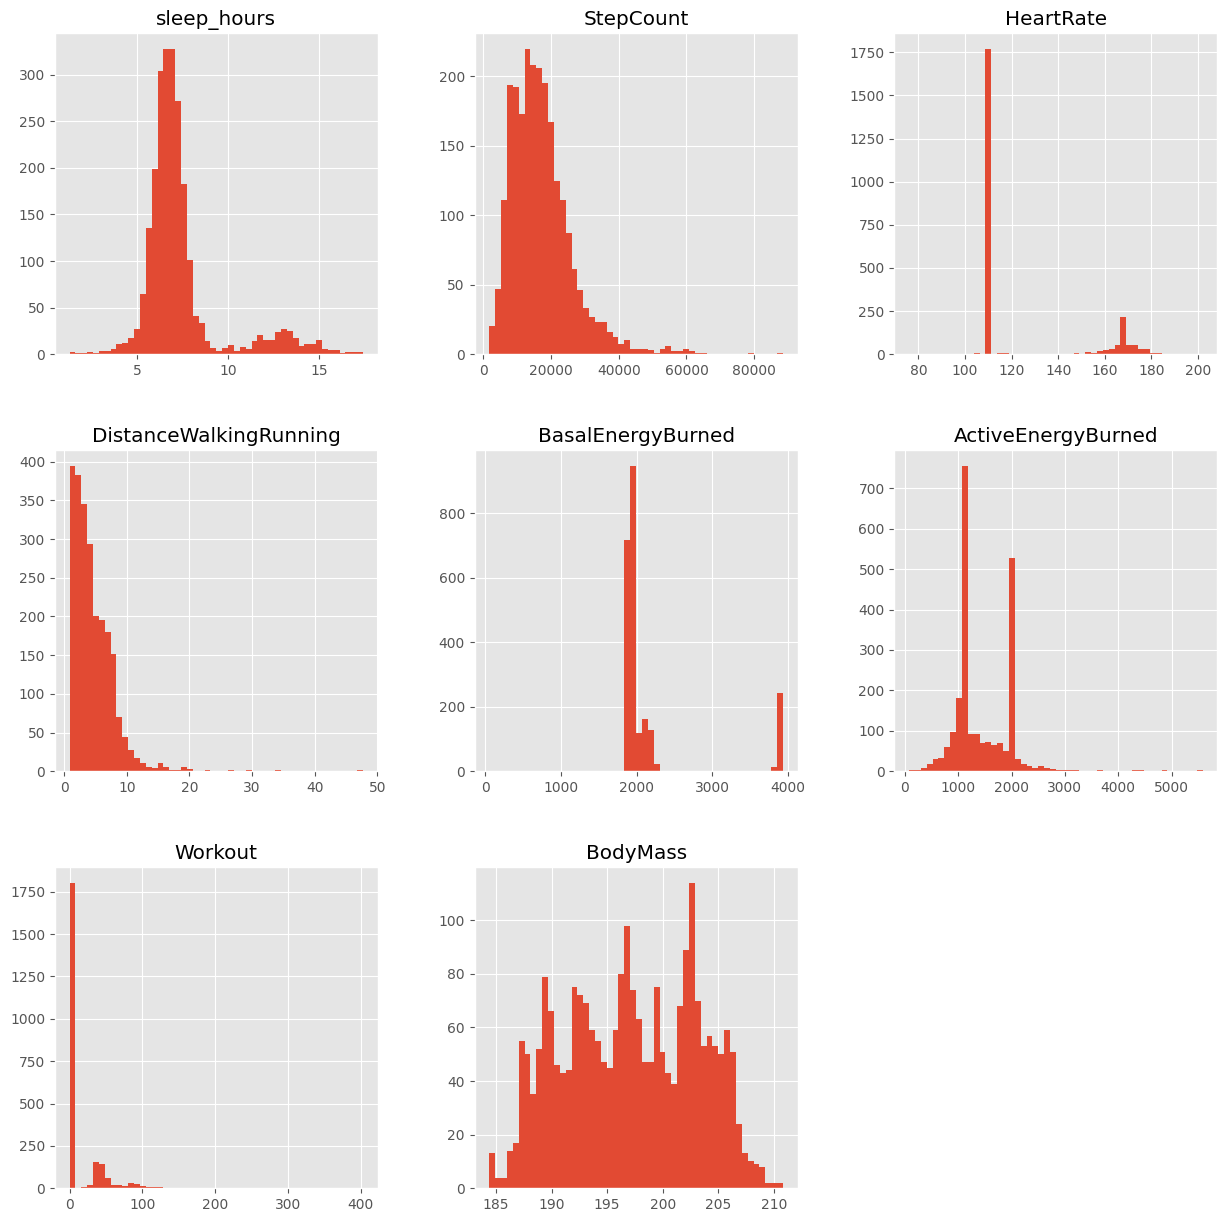

In [15]:
train_impute.hist(bins = 50,figsize = (15,15))
plt.show()

# Treat Outliers in Target Variable

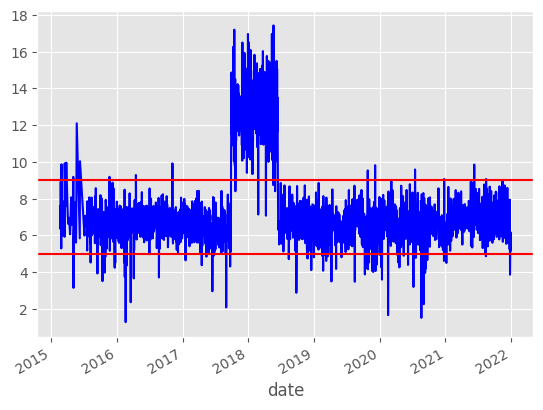

In [14]:
train['sleep_hours'].plot(color='blue')
upperbound = 9
lowerbound = 5
plt.axhline(upperbound, color='red')
plt.axhline(lowerbound, color='red')
plt.show()

In [15]:
train_out = train.copy()
# Double count data
train_out.loc[train_out['sleep_hours'] > upperbound, 'sleep_hours'] = train_out['sleep_hours'] / 2
train_out.loc[train_out['sleep_hours'] > upperbound, 'sleep_hours'] = train_out['sleep_hours'].rolling(7).mean()
# low data smoothing
train_out.loc[train_out['sleep_hours'] < lowerbound, 'sleep_hours'] = train_out['sleep_hours'].rolling(7).mean()
train_out.head()

,sleep_hours
date,
2015-02-19,6.400000
2015-02-20,7.583333
2015-02-21,6.350000
2015-02-22,6.500000
2015-02-23,8.916667


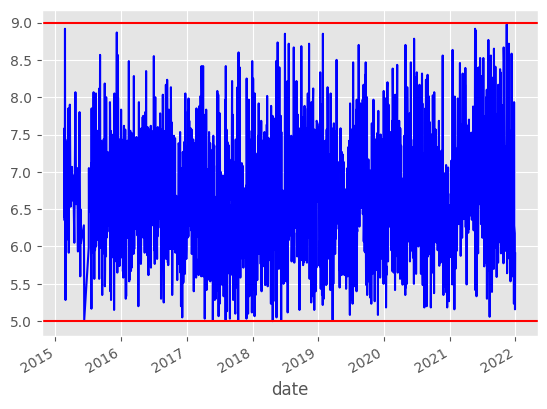

In [17]:
train_out['sleep_hours'].plot(color='blue')
plt.axhline(upperbound, color='red')
plt.axhline(lowerbound, color='red')
plt.show()

# Log Transformation

In [16]:
train_out['sleep_hours'] = np.log(train_out['sleep_hours'])
train_out.head()

,sleep_hours
date,
2015-02-19,1.856298
2015-02-20,2.025953
2015-02-21,1.848455
2015-02-22,1.871802
2015-02-23,2.187922


# Feature Engineering

In [17]:
def createDateFeatures(data):
    temp = data.copy()
    temp['day'] = temp.index.day
    temp['month'] = temp.index.month
    temp['year'] = temp.index.year
    temp['weekofyear'] = temp.index.isocalendar().week.astype('int')
    temp['weekday'] = temp.index.weekday
    temp['dayofyear'] = temp.index.day_of_year
    
    temp['date_offset'] = (temp.index.month * 100 + temp.index.day - 320) % 1300
    temp['season'] = pd.cut(temp['date_offset'], 
                            bins=[0, 300, 602, 900, 1300],
                            labels=['spring', 'summer', 'fall', 'winter'])
    temp.drop('date_offset', axis=1, inplace=True)
    
    temp2 = pd.get_dummies(temp['season'])
    temp.drop('season', axis=1, inplace=True)
    temp = temp.merge(temp2, how='left', left_index=True, right_index=True)
    
    return temp

In [18]:
train_new = createDateFeatures(train_out)
train_new.head()

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter
date,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1


In [19]:
'''
    Our forecasting horizon is >1 years, 
    hence for lag of days, we'll compute iteratively from previous predictions.
'''
# Lag Features
def createLagFeatures(data):
    temp = data.copy()
    n=3 # Num of Lags
    # Day lag (3 days)
    for i in range(1, n+1):
        temp[f'day_lag_{i}'] = temp['sleep_hours'].shift(i)
        temp[f'day_lag_{i}'] = temp[f'day_lag_{i}'].bfill()
    # Year lag (1 year)
    temp[f'year_lag_{1}'] = temp['sleep_hours'].shift(364)
    temp[f'year_lag_{1}'] = temp[f'year_lag_{1}'].bfill()
    return temp

def random_noise(data):
    return np.random.normal(scale=1.5, size=(len(data)))
# Roll mean Features
def createRollMeanFeatures(data):
    windows = [3,7,14,28]
    temp = data.copy()
    for window in windows:
        temp['roll_mean_' + str(window)] = \
            temp['sleep_hours'].shift(1).rolling(window=window, win_type="triang").mean() \
                + random_noise(temp)
        temp['roll_mean_' + str(window)] = temp['roll_mean_' + str(window)].bfill()
    return temp

# Exponential Weighted Moving Average
def createEWMFeatures(data):
    alphas = [0.95,0.8]
    lags = [3,7,14,28]
    temp = data.copy()
    for alpha in alphas:
        for lag in lags:
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['sleep_hours'].shift(lag).ewm(alpha=alpha).mean()
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)].bfill()
    return temp

In [20]:
train_new = createLagFeatures(train_new)
train_new = createRollMeanFeatures(train_new)
train_new = createEWMFeatures(train_new)
train_new.head(10)

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1,2.025953,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1,1.848455,2.025953,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1,1.871802,1.848455,2.025953,1.856298,-0.264398,1.286882,-0.966165,2.711888,2.017874,1.856298,1.856298,1.856298,1.997677,1.856298,1.856298,1.856298
2015-02-24,1.887070,24,2,2015,9,1,55,0,0,0,1,2.187922,1.871802,1.848455,1.856298,1.406159,1.286882,-0.966165,2.711888,1.856906,1.856298,1.856298,1.856298,1.877337,1.856298,1.856298,1.856298
2015-02-25,1.827234,25,2,2015,9,2,56,0,0,0,1,1.887070,2.187922,1.871802,1.856298,-1.346351,1.286882,-0.966165,2.711888,1.871057,1.856298,1.856298,1.856298,1.872902,1.856298,1.856298,1.856298
2015-02-26,1.664557,26,2,2015,9,3,57,0,0,0,1,1.827234,1.887070,2.187922,1.856298,0.398552,1.286882,-0.966165,2.711888,2.172079,1.856298,1.856298,1.856298,2.124999,1.856298,1.856298,1.856298
2015-02-27,1.856298,27,2,2015,9,4,58,0,0,0,1,1.664557,1.827234,1.887070,1.856298,2.350699,2.726583,-0.966165,2.711888,1.901320,2.017874,1.856298,1.856298,1.934643,1.997677,1.856298,1.856298


In [21]:
import holidays

def get_holidays(df):
    years_list = np.arange(train_new.index.year.min(), train_new.index.year.max()+1)

    holiday_US = holidays.CountryHoliday('US', years = years_list)

    df['holiday_name'] = df.index.map(holiday_US)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])

In [22]:
train_new = get_holidays(train_new)
train_new.head()

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1,2.025953,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1,1.848455,2.025953,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1,1.871802,1.848455,2.025953,1.856298,-0.264398,1.286882,-0.966165,2.711888,2.017874,1.856298,1.856298,1.856298,1.997677,1.856298,1.856298,1.856298,0


# Merge XML and New Train data

In [23]:
train_new.shape, train_impute.shape

((2354, 28), (2354, 8))

In [24]:
temp = train_impute.drop('sleep_hours', axis=1)
train_fin = train_new.merge(temp, how='left', left_index=True, right_index=True)
train_fin.head()

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0,2669,110.0,1.31187,1898.0,487.0,0.0,188.799
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1,1.856298,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0,14552,110.0,7.16791,1898.0,1789.0,0.0,188.799
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1,2.025953,1.856298,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0,7769,110.0,3.82391,1898.0,1185.0,0.0,188.799
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1,1.848455,2.025953,1.856298,1.856298,1.011386,1.286882,-0.966165,2.711888,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0,16675,110.0,8.19599,1898.0,2173.0,0.0,188.799
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1,1.871802,1.848455,2.025953,1.856298,-0.264398,1.286882,-0.966165,2.711888,2.017874,1.856298,1.856298,1.856298,1.997677,1.856298,1.856298,1.856298,0,6076,110.0,2.98648,1898.0,903.0,0.0,188.799


In [25]:
train_fin.shape, train_fin.isna().sum()

((2354, 35),
 sleep_hours               0
 day                       0
 month                     0
 year                      0
 weekofyear                0
 weekday                   0
 dayofyear                 0
 spring                    0
 summer                    0
 fall                      0
 winter                    0
 day_lag_1                 0
 day_lag_2                 0
 day_lag_3                 0
 year_lag_1                0
 roll_mean_3               0
 roll_mean_7               0
 roll_mean_14              0
 roll_mean_28              0
 ewm_alpha_095_lag_3       0
 ewm_alpha_095_lag_7       0
 ewm_alpha_095_lag_14      0
 ewm_alpha_095_lag_28      0
 ewm_alpha_08_lag_3        0
 ewm_alpha_08_lag_7        0
 ewm_alpha_08_lag_14       0
 ewm_alpha_08_lag_28       0
 is_holiday                0
 StepCount                 0
 HeartRate                 0
 DistanceWalkingRunning    0
 BasalEnergyBurned         0
 ActiveEnergyBurned        0
 Workout                   0
 

# Split Feature and Target

In [26]:
X = train_fin.drop('sleep_hours', axis=1)
y = train_fin['sleep_hours']

In [27]:
X.columns

Index(['day', 'month', 'year', 'weekofyear', 'weekday', 'dayofyear', 'spring',
       'summer', 'fall', 'winter', 'day_lag_1', 'day_lag_2', 'day_lag_3',
       'year_lag_1', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
       'roll_mean_28', 'ewm_alpha_095_lag_3', 'ewm_alpha_095_lag_7',
       'ewm_alpha_095_lag_14', 'ewm_alpha_095_lag_28', 'ewm_alpha_08_lag_3',
       'ewm_alpha_08_lag_7', 'ewm_alpha_08_lag_14', 'ewm_alpha_08_lag_28',
       'is_holiday', 'StepCount', 'HeartRate', 'DistanceWalkingRunning',
       'BasalEnergyBurned', 'ActiveEnergyBurned', 'Workout', 'BodyMass'],
      dtype='object')

# Train and Validation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1883, 34), (471, 34), (1883,), (471,))

# Neural Network - PyTorch Implementation

In [ ]:
# tensorboard logs
from datetime import datetime
from keras.callbacks import TensorBoard, ReduceLROnPlateau
log_dir=f"{HOME}logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# metric='rmse'
metric='mean_absolute_error'

# callbaks 
tensorboard_callback = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False,
                                   update_freq='epoch')

# reduce learning Rate
reducelr = ReduceLROnPlateau(monitor=metric,
                             factor=np.sqrt(.01),
                             patience=2, #patcience
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.00001)

### converting to tensor

In [51]:
X_train_pt = torch.tensor(X_train.values, dtype=torch.float32)
X_test_pt = torch.tensor(X_test.values, dtype=torch.float32)
y_train_pt = torch.tensor(y_train.values, dtype=torch.float32)
y_test_pt = torch.tensor(y_test.values, dtype=torch.float32)
X_train_pt.shape, X_test_pt.shape, y_train_pt.shape, y_test_pt.shape

(torch.Size([1883, 34]),
 torch.Size([471, 34]),
 torch.Size([1883]),
 torch.Size([471]))

### Checking for Cuda

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

Running on: cuda


In [53]:
X_train_pt = X_train_pt.to(device)
X_test_pt = X_test_pt.to(device)
y_train_pt = y_train_pt.to(device)
y_test_pt = y_test_pt.to(device)

Running on: cuda


### Model

In [63]:
batch_size = 8

# Create a DataLoader for the training set
train_dataset = TensorDataset(X_train_pt, y_train_pt)
val_dataset = TensorDataset(X_test_pt, y_test_pt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # (len(X_train_pt)/batch_size, batch_size, n_features) == (236, 8, 34)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Estimate Loss on Validation set
@torch.no_grad()
def estimate_val():
    model.eval() # Switch to Evaluation mode
    val_loss = 0
    for x, y in val_loader:
        outputs = model(x).view(-1)
        loss = criterion(outputs, y)
        val_loss += loss.item()
    val_loss /= len(val_loader)
    model.train() # Switch to Training mode
    return val_loss
    
class MyModel(nn.Module):
    n1 = 64
    n2 = 32
    n3 = 16
    n4 = 1
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(X_train_pt.shape[1], self.n1)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(self.n1, self.n2)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(self.n2, self.n3)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(self.n3, self.n4)

    def forward (self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        logits = self.fc4(x)
            
        return logits
    
# Build Model
model = MyModel().to(device)
criterion = nn.MSELoss()

# Add Logs for TensorBoard
log_dir=f"{HOME}torchlogs/"
writer = SummaryWriter(log_dir)
writer.add_graph(model, X_train_pt) # writer.add_graph(model, torch.randn(1, X_train_pt.shape[1]).to(device))
writer.close()

# create a PyTorch optimizer (Adam w/ Weight Decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

# Gradient Descent
epochs = 50
early_stop = 10

# Define early stopping parameters
patience = 10
delta = 0.001
best_loss = float('inf')
best_model = None
counter = 0

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}/{epochs}")
                
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, total=len(train_loader)):
        
        # sample a batch of data
        xb, yb = xb.to(device), yb.to(device)
        
        # forward
        y_pred = model(xb)
        y_pred = y_pred.view(-1)
        loss = criterion(yb, y_pred)
        
        # backward
        loss.backward()
        train_loss += loss.item()
        
        # update weights
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
    train_loss /= len(train_loader)
    train_rmse = np.sqrt(train_loss)
    
    # Evaluate the model on the validation set
    val_loss = estimate_val()
    val_rmse = np.sqrt(val_loss)
    
    # Check if validation loss has improved
    if val_loss < best_loss - delta:
        best_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Validation loss did not improve for {} epochs. Stopping training.".format(patience))
            break
    
    print(f'loss: {train_loss} - rmse: {train_rmse} - val_loss: {val_loss} - val_rmse: {val_rmse}')
    
# Load the best model
if best_model is not None:
    model.load_state_dict(best_model)

Epoch 1/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 678405.5527863796 - rmse: 823.6537821113793 - val_loss: 2.68696867409399 - val_rmse: 1.6391975701830424
Epoch 2/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 100.74263257596452 - rmse: 10.037062945701024 - val_loss: 2.648570072852959 - val_rmse: 1.6274428017146898
Epoch 3/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 309.15311367531956 - rmse: 17.582750458199637 - val_loss: 2.62138035741903 - val_rmse: 1.6190677433075584
Epoch 4/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 5.53801288493609 - rmse: 2.353298299182679 - val_loss: 2.5253967632681635 - val_rmse: 1.5891496981933966
Epoch 5/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 3.120753952507245 - rmse: 1.7665655811509646 - val_loss: 2.414947125871303 - val_rmse: 1.5540100147268365
Epoch 6/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 3.365327956817918 - rmse: 1.8344830216761119 - val_loss: 2.279780412124375 - val_rmse: 1.5098941724916932
Epoch 7/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 2.301390961570255 - rmse: 1.517033605946241 - val_loss: 2.132841795177783 - val_rmse: 1.4604252104020197
Epoch 8/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 2.283684529995514 - rmse: 1.51118646433705 - val_loss: 1.976128760030714 - val_rmse: 1.4057484696881992
Epoch 9/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.8989920136282 - rmse: 1.3780391916154635 - val_loss: 1.8123495740405584 - val_rmse: 1.3462353338256126
Epoch 10/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.7342479496689167 - rmse: 1.3169084818881367 - val_loss: 1.6448356034392018 - val_rmse: 1.2825114437848895
Epoch 11/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.8136856343786596 - rmse: 1.3467314633506784 - val_loss: 1.479434538695772 - val_rmse: 1.2163200806924845
Epoch 12/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.3940296258966802 - rmse: 1.1806903175247438 - val_loss: 1.3154106200751612 - val_rmse: 1.1469135190044457
Epoch 13/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.2319225661330304 - rmse: 1.1099200719569993 - val_loss: 1.1572507882522325 - val_rmse: 1.0757559148116418
Epoch 14/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.0764569804324942 - rmse: 1.037524448113149 - val_loss: 1.0072903410863068 - val_rmse: 1.0036385510164039
Epoch 15/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.9355159376637411 - rmse: 0.9672207285122363 - val_loss: 0.8665337087744374 - val_rmse: 0.9308779236690692
Epoch 16/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.7991954472105381 - rmse: 0.8939773191812744 - val_loss: 0.7378148840645612 - val_rmse: 0.8589615148914189
Epoch 17/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.6773584449695329 - rmse: 0.8230178886084633 - val_loss: 0.621840816938271 - val_rmse: 0.7885688409633436
Epoch 18/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.5677827375672632 - rmse: 0.7535135948125045 - val_loss: 0.5185569949069265 - val_rmse: 0.7201090159878062
Epoch 19/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.4794080254258746 - rmse: 0.6923929703758369 - val_loss: 0.4334702011892351 - val_rmse: 0.6583845389961972
Epoch 20/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.39215026379136714 - rmse: 0.6262190222209536 - val_loss: 0.35455416016659497 - val_rmse: 0.5954445063703208
Epoch 21/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.3194253911280026 - rmse: 0.565177309459609 - val_loss: 0.28915375294321677 - val_rmse: 0.5377301860070873
Epoch 22/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.2528640839066041 - rmse: 0.5028559275842377 - val_loss: 0.2448620659820104 - val_rmse: 0.49483539281463124
Epoch 23/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.16367725593874516 - rmse: 0.40457045855913054 - val_loss: 0.10162043836662325 - val_rmse: 0.3187796078274507
Epoch 24/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.14103203172148285 - rmse: 0.3755423168186015 - val_loss: 0.10434946575659816 - val_rmse: 0.323031679184253
Epoch 25/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.14275795437584995 - rmse: 0.3778332361979951 - val_loss: 0.06771127885933649 - val_rmse: 0.2602139098114021
Epoch 26/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.12946632172186243 - rmse: 0.35981428782340263 - val_loss: 0.07810638826024735 - val_rmse: 0.279475201512133
Epoch 27/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.12882154532787154 - rmse: 0.3589171844978609 - val_loss: 0.08339414770825435 - val_rmse: 0.2887804489716268
Epoch 28/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.11418106664224702 - rmse: 0.33790689049240624 - val_loss: 0.06628343361919209 - val_rmse: 0.2574556925360014
Epoch 29/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.09781374119348445 - rmse: 0.31275188439637647 - val_loss: 0.057215076097745 - val_rmse: 0.23919673095120886
Epoch 30/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0849342752697925 - rmse: 0.29143485596234453 - val_loss: 0.052411935339539736 - val_rmse: 0.22893653124728638
Epoch 31/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.07033322171023967 - rmse: 0.2652041132981155 - val_loss: 0.044970387182498385 - val_rmse: 0.21206222478908965
Epoch 32/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.060986369613447555 - rmse: 0.24695418525193608 - val_loss: 0.03474164305854652 - val_rmse: 0.18639110241249854
Epoch 33/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.05342048658768378 - rmse: 0.23112872298285167 - val_loss: 0.031058384610687273 - val_rmse: 0.1762338917764891
Epoch 34/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.045141570475268164 - rmse: 0.21246545713425552 - val_loss: 0.026728673080392812 - val_rmse: 0.1634890610419939
Epoch 35/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.041592499269843416 - rmse: 0.20394239203717165 - val_loss: 0.023037669643507164 - val_rmse: 0.15178165120826417
Epoch 36/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0335343891174643 - rmse: 0.18312397199019112 - val_loss: 0.02349815727606163 - val_rmse: 0.15329108674695222
Epoch 37/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.03205230772905683 - rmse: 0.17903158304907218 - val_loss: 0.024218678048227804 - val_rmse: 0.15562351380247075
Epoch 38/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.027846016380462354 - rmse: 0.1668712569032257 - val_loss: 0.018207389198369898 - val_rmse: 0.13493475904439856
Epoch 39/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0251645056177641 - rmse: 0.15863324247383995 - val_loss: 0.017558510967735516 - val_rmse: 0.1325085316790414
Epoch 40/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.02256958793761935 - rmse: 0.15023178071772747 - val_loss: 0.018069694710548145 - val_rmse: 0.13442356456569712
Epoch 41/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.020496363723966276 - rmse: 0.14316551164287533 - val_loss: 0.015993923619705235 - val_rmse: 0.12646708512377927
Epoch 42/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.018793452568589 - rmse: 0.13708921390316964 - val_loss: 0.01552728894245574 - val_rmse: 0.12460854281491193
Epoch 43/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.017641133876908098 - rmse: 0.13281993026992636 - val_loss: 0.015167609851617934 - val_rmse: 0.12315685060774303
Epoch 44/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.016331084259051703 - rmse: 0.12779313071934542 - val_loss: 0.016989484808202518 - val_rmse: 0.13034371794682903
Epoch 45/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.015510944061087823 - rmse: 0.12454294063128517 - val_loss: 0.0168546731820551 - val_rmse: 0.12982554903429103
Epoch 46/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.014807186240401372 - rmse: 0.12168478228768531 - val_loss: 0.014913926650848935 - val_rmse: 0.12212258861835895
Epoch 47/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.014678528778041886 - rmse: 0.12115497834609144 - val_loss: 0.012937533416611663 - val_rmse: 0.11374327855575318
Epoch 48/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013953004745663918 - rmse: 0.11812283752798998 - val_loss: 0.012274158739690053 - val_rmse: 0.11078880241111938
Epoch 49/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013708852576308932 - rmse: 0.11708480933199204 - val_loss: 0.012763656304865065 - val_rmse: 0.11297635285698095
Epoch 50/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013355087500235256 - rmse: 0.11556421375250756 - val_loss: 0.012112351615865857 - val_rmse: 0.11005612938798937


In [ ]:
# Tensorboard
!cd {log_dir}
!tensorboard dev upload --logdir ./

In [64]:
print("Total Number of Parameters:", sum(p.numel() for p in model.parameters()))

Total Number of Parameters: 4865


In [77]:
with torch.no_grad():
    model.eval() # Switch to Evaluation mode
    y_pred = model(X_test_pt)
    y_pred = y_pred.view(-1)
    mse = criterion(y_test_pt, y_pred).cpu().numpy()
    rmse = np.sqrt(mse)
    mape = np.round(mean_absolute_percentage_error(y_test_pt.cpu().numpy(), y_pred.cpu().numpy()) * 100, 2)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE: {} %".format(mape))
    model.train() # Switch to Training mode

MSE: 0.012126778
RMSE: 0.11012165
MAPE: 4.74 %


# Predict on Test Set

In [35]:
test.drop('sleep_hours', axis=1, inplace=True)
test.head(10)

""
date
2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05
2022-01-06
2022-01-07
2022-01-08
2022-01-19


In [36]:
test_xml = xml_data(test)
test_xml.head()

,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,
2022-01-01,20201,169.000,4.22901,2042.550,1772.419,80.672081,189.6
2022-01-02,25672,167.903,8.66981,2003.146,2990.995,164.242422,192.8
2022-01-03,20034,175.177,5.06094,2072.489,1971.896,98.093096,193.4
2022-01-04,15050,173.000,4.08979,2001.038,1562.286,76.400812,191.0
2022-01-05,16803,173.909,7.23904,1968.489,2292.182,140.844011,NaN


In [37]:
test_impute = xml_impute(test_xml)

Pre-Imputation
 StepCount                   0
HeartRate                   1
DistanceWalkingRunning      0
BasalEnergyBurned           1
ActiveEnergyBurned          1
Workout                   132
BodyMass                  316
dtype: int64
Post-Imputation
 StepCount                 0
HeartRate                 0
DistanceWalkingRunning    0
BasalEnergyBurned         0
ActiveEnergyBurned        0
Workout                   0
BodyMass                  0
dtype: int64


In [38]:
train_test = pd.concat((train_out, test), axis=0)
train_test

,sleep_hours
date,
2015-02-19,1.856298
2015-02-20,2.025953
2015-02-21,1.848455
2015-02-22,1.871802
2015-02-23,2.187922
...,...
2023-03-12,NaN
2023-03-13,NaN
2023-03-14,NaN


In [39]:
train_test = createDateFeatures(train_test)
train_test = createLagFeatures(train_test)
train_test = createRollMeanFeatures(train_test)
train_test = createEWMFeatures(train_test)
train_test = get_holidays(train_test)
train_test

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1,1.856298,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1,1.856298,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1,2.025953,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1,1.848455,2.025953,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1,1.871802,1.848455,2.025953,1.856298,4.104539,3.325597,2.656051,2.666612,2.017874,1.856298,1.856298,1.856298,1.997677,1.856298,1.856298,1.856298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,NaN,12,3,2023,10,6,71,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0
2023-03-13,NaN,13,3,2023,11,0,72,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0
2023-03-14,NaN,14,3,2023,11,1,73,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0


In [40]:
# Remember actual test data start from >2021 (i.e., from 2022), 
# but here we are considering 1 year of training data to compute lag features iteratively with prediction
test_new = train_test[train_test.index.year>2019]

In [41]:
test_merge = test_new.merge(test_impute, how='left', left_index=True, right_index=True)
test_merge

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.848080,1,1,2020,1,2,1,0,0,0,1,2.089804,1.704748,1.824549,1.887070,2.484595,2.157827,0.676702,-0.320160,1.827996,1.828060,1.807234,1.811844,1.838589,1.828364,1.820884,1.827806,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1.752094,2,1,2020,1,3,2,0,0,0,1,1.848080,2.089804,1.704748,1.743386,1.981706,1.383927,2.888755,1.658626,1.710910,1.829819,1.913764,1.907000,1.731516,1.829602,1.899673,1.895168,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1.943526,3,1,2020,1,4,3,0,0,0,1,1.752094,1.848080,2.089804,2.039053,1.235353,0.678437,3.845081,2.785090,2.070860,1.919527,1.900324,1.902352,2.018147,1.905319,1.899628,1.900720,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,2.008214,4,1,2020,1,5,4,0,0,0,1,1.943526,1.752094,1.848080,2.032525,2.156095,0.022728,1.088418,0.740770,1.859219,1.893478,1.987825,1.865818,1.882093,1.894750,1.973870,1.871260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1.840550,5,1,2020,1,6,5,0,0,0,1,2.008214,1.943526,1.752094,1.887430,1.511052,2.873878,1.996431,3.663316,1.757450,1.827996,2.005067,1.912036,1.778094,1.838589,1.999553,1.905827,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,NaN,12,3,2023,10,6,71,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,6865.0,125.0,3.238917,2117.631,440.980,0.000000,201.0
2023-03-13,NaN,13,3,2023,11,0,72,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,13752.0,183.0,4.218030,2196.882,1678.721,82.307355,201.8
2023-03-14,NaN,14,3,2023,11,1,73,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,21737.0,181.0,5.933210,2189.984,2289.884,112.872589,201.8


In [42]:
test_merge.columns

Index(['sleep_hours', 'day', 'month', 'year', 'weekofyear', 'weekday',
       'dayofyear', 'spring', 'summer', 'fall', 'winter', 'day_lag_1',
       'day_lag_2', 'day_lag_3', 'year_lag_1', 'roll_mean_3', 'roll_mean_7',
       'roll_mean_14', 'roll_mean_28', 'ewm_alpha_095_lag_3',
       'ewm_alpha_095_lag_7', 'ewm_alpha_095_lag_14', 'ewm_alpha_095_lag_28',
       'ewm_alpha_08_lag_3', 'ewm_alpha_08_lag_7', 'ewm_alpha_08_lag_14',
       'ewm_alpha_08_lag_28', 'is_holiday', 'StepCount', 'HeartRate',
       'DistanceWalkingRunning', 'BasalEnergyBurned', 'ActiveEnergyBurned',
       'Workout', 'BodyMass'],
      dtype='object')

In [43]:
train_part_len = len(test_merge[test_merge.index.year<2022])
train_part_len

714

In [44]:
test_merge.shape

(1133, 35)

## Forcast

In [88]:
test_iter_target = test_merge.copy()
with torch.no_grad():
    model.eval() # Switch to Evaluation mode
    for i in tqdm(range(len(test))):
        data_val = test_iter_target.iloc[train_part_len+i,1:].to_numpy()
        data_val = torch.tensor(data_val, dtype=torch.float32)
        data_val = data_val.to(device)
        pred_val = model(data_val)
        pred_val = pred_val.view(-1)
        
        # update target iteratively with prediction
        test_iter_target.iloc[train_part_len+i,0] = pred_val.item()

        # update roll_mean iteratively with prediction
        test_iter_target = createLagFeatures(test_iter_target)
        test_iter_target = createRollMeanFeatures(test_iter_target)
        test_iter_target = createEWMFeatures(test_iter_target)
    model.train() # Switch to Training mode

  0%|          | 0/419 [00:00<?, ?it/s]

In [89]:
test_final = test_iter_target[test_iter_target.index.year>2021]

### Inverse log transformation

In [90]:
test_y = np.exp(test_final['sleep_hours'])

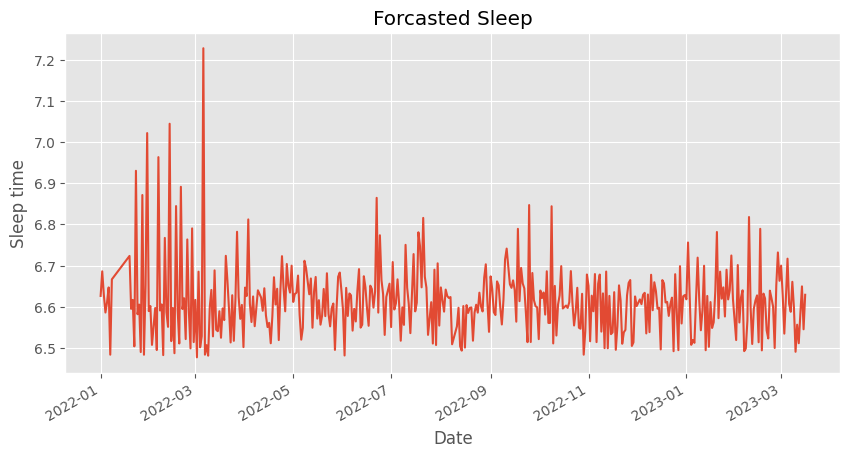

In [95]:
plt.figure(figsize=(10,5))
test_y.plot()
plt.title('Forcasted Sleep')
plt.ylabel('Sleep time')
plt.xlabel('Date')
plt.show()

# Ensemble Model

In [29]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Individual Learners

In [30]:
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

from sklearn.metrics import make_scorer
my_scorer = make_scorer(rmse, greater_is_better=False)

def grid_search(model, searchSpace, x, y, verbose=4, cv = 5):
    np.random.seed(42)
    
    # Initialize GridSearchCV
    gs = GridSearchCV(model, param_grid=searchSpace, scoring=my_scorer, cv=cv, refit=True, verbose=verbose)
    
#     # Use tqdm to create a loading bar
#     total_params = [len(searchSpace[key]) for key in searchSpace.keys()]
#     total_params = math.prod(total_params)
    
#     with tqdm(total=total_params, desc="Grid Search Progress") as pbar:
#         # Custom progress bar update function
#         def update_progress(estimator, X, y):
#             pbar.update(1)  # Increment the progress bar

#         # Set the progress callback
#         gs.progress_callback = update_progress

    # Fit the grid search to the data
    gs.fit(x, y)
    
    # Print the best parameters and score
    print()
    print("Best parameters: ", gs.best_params_)
    print("Best score: ", gs.best_score_)
    
    return gs

### Decision Tree

In [75]:
dec_tree = DecisionTreeRegressor(random_state=42)

# SearchSpace
searchSpace = {
    'criterion': ["squared_error", "friedman_mse"],
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.119 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=2;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.113 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=4;, score=-0.119 total time= 

In [78]:
''' By previous GridSearch Run, it looks like we can go higher on min_samples_split '''

# SearchSpace
searchSpace = {
    'criterion': ["squared_error"],
    'max_depth': [5],
    'min_samples_split': [10, 15, 20]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.116 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=10;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=15;, score=-0.117 total

In [83]:
''' Let's set even higher value for min_samples_split '''

# SearchSpace
searchSpace = {
    'criterion': ["squared_error"], 
    'max_depth': [5],
    'min_samples_split': [20, 50, 100, 150, 500, 1000, 2000]
}

dec_gs = grid_search(dec_tree, searchSpace, X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.117 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.117 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.118 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.120 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.116 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.112 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.114 total

In [84]:
score = cross_val_score(dec_gs, X_train, y_train, cv=10)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.114 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.114 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.111 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, min_samples_split=20;, score=-0.121 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.119 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.112 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.114 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, min_samples_split=50;, score=-0.109 total

In [85]:
score

array([-0.11681739, -0.11050197, -0.10987398, -0.11138552, -0.10992735,
       -0.11027842, -0.11288172, -0.10206279, -0.10795301, -0.1180055 ])

**Scores are pretty descent**

### Random Forest

In [89]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'criterion': ["squared_error", "friedman_mse"], 
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.112 total time=   0.2s
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.108 total time=   0.2s
[CV 3/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.109 total time=   0.2s
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.107 total time=   0.2s
[CV 5/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.112 total time=   0.3s
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_split=2, n_estimators=100;, sc

In [90]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [200, 300, 400],
    'criterion': ["friedman_mse"],
    'max_depth': [5],
    'min_samples_split': [2]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.112 total time=   0.6s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.108 total time=   0.6s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.108 total time=   0.6s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.107 total time=   0.6s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=200;, score=-0.110 total time=   0.6s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.112 total time=   0.9s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=300;, score=-0.108 total time=   0.9s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=30

In [91]:
ran_forest = RandomForestRegressor(random_state=42, max_features='sqrt', bootstrap=True)

# SearchSpace
searchSpace = {
    'n_estimators': [400, 600, 800],
    'criterion': ["friedman_mse"],
    'max_depth': [5],
    'min_samples_split': [2]
}

ran_gs = grid_search(ran_forest, searchSpace, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.112 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.108 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.108 total time=   1.2s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.107 total time=   1.2s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.2s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.112 total time=   1.9s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.108 total time=   1.9s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=60

In [93]:
score = cross_val_score(ran_gs, X_train, y_train, cv=10)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.111 total time=   1.2s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.106 total time=   1.2s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.3s
[CV 4/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.106 total time=   1.2s
[CV 5/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=400;, score=-0.110 total time=   1.2s
[CV 1/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.110 total time=   1.8s
[CV 2/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=600;, score=-0.106 total time=   1.8s
[CV 3/5] END criterion=friedman_mse, max_depth=5, min_samples_split=2, n_estimators=60

In [94]:
score

array([-0.11480452, -0.1103527 , -0.10898201, -0.10733326, -0.10842364,
       -0.10791492, -0.11135623, -0.10268021, -0.10291638, -0.11710867])

### ADA Boost

In [32]:
ada_boost = AdaBoostRegressor(random_state=42)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

ada_gs = grid_search(ada_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=-0.113 total time=   0.5s
[CV 2/5] END learning_rate=0.01, n_estimators=50;, score=-0.109 total time=   0.5s
[CV 3/5] END learning_rate=0.01, n_estimators=50;, score=-0.108 total time=   0.5s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=-0.107 total time=   0.5s
[CV 5/5] END learning_rate=0.01, n_estimators=50;, score=-0.111 total time=   0.5s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=-0.112 total time=   1.1s
[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=-0.109 total time=   1.1s
[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=-0.108 total time=   1.1s
[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=-0.106 total time=   1.1s
[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=-0.111 total time=   1.1s
[CV 1/5] END learning_rate=0.01, n_estimators=200;, score=-0.112 total time=   2.1s
[CV 2/5] END learnin

In [35]:
score = cross_val_score(ada_boost, X_train, y_train, cv=10)

In [36]:
score

array([ 0.0296562 ,  0.03034349,  0.06617951, -0.00294066,  0.0251807 ,
        0.02260289,  0.02708428, -0.02191224, -0.06104863, -0.04501389])

### Gradient Boost

In [41]:
grad_boost = GradientBoostingRegressor(random_state=42, max_features='sqrt')

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [5, 15, 30, 50],
    'min_samples_split': [2, 4, 10]
}

grad_gs = grid_search(grad_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.113 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.109 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.108 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=50;, score=-0.110 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.113 total time=   0.3s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.110 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=2, n_estimators=100;, score=-0.109 total time=   0.4

In [42]:
grad_boost = GradientBoostingRegressor(random_state=42, max_features='sqrt')

# SearchSpace
searchSpace = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01],
    'max_depth': [5],
    'min_samples_split': [4]
}

grad_gs = grid_search(grad_boost, searchSpace, X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.113 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.109 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.109 total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.107 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=200;, score=-0.111 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.113 total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.109 total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=5, min_samples_split=4, n_estimators=300;, score=-0.109 total time=   0

In [45]:
score = cross_val_score(grad_boost, X_train, y_train, cv=10)

In [46]:
score

array([ 0.00616488, -0.02473145, -0.01165732, -0.04140249,  0.03578469,
        0.0325899 ,  0.00890336, -0.02515419, -0.07727098, -0.04414416])

### XGBoost

In [ ]:
xg_boost = XGBRegressor(random_state=42, tree_method='gpu_hist', gpu_id=0)

# SearchSpace
searchSpace = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
    'max_depth': [5, 15, 30, 50],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.3, 0.5, 0.7, 1]
}

xg_gs = grid_search(xg_boost, searchSpace, X_train, y_train)

[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.109 total time=   0.1s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.107 total time=   0.1s
[CV 5/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100;, score=-0.110 total time=   0.1s
[CV 1/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.113 total time=   0.2s
[CV 2/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.109 total time=   0.2s
[CV 3/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=200;, score=-0.109 total time=   0.2s
[CV 4/5] END colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=20

In [49]:
print("Best parameters: ", xg_gs.best_params_)
print("Best score: ", xg_gs.best_score_)

Best parameters:  {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50}
Best score:  -0.1093562521141489


In [106]:
from prettytable import PrettyTable

print("Individual Learners Performance")

table = PrettyTable()
table.field_names = ["Field",                   "Decision Tree", "Random Forest", "ADA Boost", "Gradient Boost", "XGBoost"]
table.add_row(      ["criterion",               "squared_error", "friedman_mse",  "-",         "-",               "-"     ])
table.add_row(      ["max_depth",                5,               5,              "-",         5,                 5       ])
table.add_row(      ["min_samples_split",        1000,            2,              "-",         4,                 "-"     ])
table.add_row(      ["n_estimators",             "-",             400,             100,        "-",               50      ])
table.add_row(      ["Learning Rate",            "-",             "-",             0.1,        0.01,              0.2     ])
table.add_row(      ["gamma",                    "-",             "-",            "-",         "-",               0.1     ])
table.add_row(      ["min_child_weight",         "-",             "-",            "-",         "-",               5       ])
table.add_row(      ["colsample_bytree",         "-",             "-",            "-",         "-",               0.5     ])
table.add_row(      ['------------------', '------------------', '------------------', '------------------', '------------------','------------------'])
table.add_row(      ["Neg. RMSE",                -0.1104,         -0.1092,         -0.1093,    -0.1095,           -0.1093 ])
table.add_row(      ['------------------', '------------------', '------------------', '------------------', '------------------','------------------'])
print(table)

Individual Learners Performance
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       Field        |   Decision Tree    |   Random Forest    |     ADA Boost      |   Gradient Boost   |      XGBoost       |
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     criterion      |   squared_error    |    friedman_mse    |         -          |         -          |         -          |
|     max_depth      |         5          |         5          |         -          |         5          |         5          |
| min_samples_split  |        1000        |         2          |         -          |         4          |         -          |
|    n_estimators    |         -          |        400         |        100         |         -          |         50         |
|   Learning Rate    |         -          |         -          |        

## Ensemble Training

In [60]:
# Define the number of models to train
n_models = 10

# Define the base learners
dt = DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=1000, random_state=42)
rf = RandomForestRegressor(criterion='friedman_mse', max_depth=5, min_samples_split=2, n_estimators=400, random_state=42)
ab = AdaBoostRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_split=4, random_state=42)
xgb = XGBRegressor( n_estimators=50, learning_rate=0.2, max_depth=5, colsample_bytree=0.5, gamma=0.1, min_child_weight=5, random_state=42)

# Define an empty list to store the models
models = []

np.random.seed(42)

# Train n models with different resampled datasets
for i in range(n_models):
    x_train_resampled = X_train.sample(frac=0.2).to_numpy() #here we converting to numpy array as we don't want to fit the model with feature names, as we will fit on single sample later (iteratively), which will raise feature importance error.
    selected_indices = X_train.sample(frac=0.2).index
    y_train_resampled = (y_train[selected_indices]).to_numpy()

    # Define the voting regressor
    voting_reg = VotingRegressor(
        estimators=[('dt', dt), ('rf', rf), ('ab', ab), ('gb', gb), ('xgb', xgb)], 
        verbose=True
    )
    
    # Fit the voting classifier on the resampled training data
    voting_reg.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_reg)

[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.5s
[Voting] ....................... (3 of 5) Processing ab, total=   0.5s
[Voting] ....................... (4 of 5) Processing gb, total=   0.5s
[Voting] ...................... (5 of 5) Processing xgb, total=   0.1s
[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.5s
[Voting] ....................... (3 of 5) Processing ab, total=   0.4s
[Voting] ....................... (4 of 5) Processing gb, total=   0.4s
[Voting] ...................... (5 of 5) Processing xgb, total=   0.1s
[Voting] ....................... (1 of 5) Processing dt, total=   0.0s
[Voting] ....................... (2 of 5) Processing rf, total=   1.6s
[Voting] ....................... (3 of 5) Processing ab, total=   0.3s
[Voting] ....................... (4 of 5) Processing gb, total=   0.4s
[Votin

In [103]:
y_preds = []
x = X_train.to_numpy()
for model in models:
    y_pred = model.predict(x)
    y_preds.append(y_pred)
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg, 2)

In [104]:
mse = mean_squared_error(y_train, y_pred_final)
rmse = np.sqrt(mse)
mape = np.round(mean_absolute_percentage_error(y_train, y_pred_final) * 100, 2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE: {} %".format(mape))

MSE: 0.012446967949336685
RMSE: 0.11156598025086628
MAPE: 4.76 %


# Predict on Test set

In [94]:
test_iter_target = test_merge.copy()
for i in tqdm(range(len(test))):
    data_val = test_iter_target.iloc[train_part_len+i,1:].to_numpy().reshape(1, -1)
    y_preds = []
    for model in models:
        y_pred = model.predict(data_val)
        y_preds.append(y_pred)
    y_pred_avg = np.mean(y_preds, axis=0)
    y_pred_final = np.round(y_pred_avg, 2)
    
    # update target iteratively with prediction
    test_iter_target.iloc[train_part_len+i,0] = y_pred_final
    # update roll_mean iteratively with prediction
    test_iter_target = createLagFeatures(test_iter_target)
    test_iter_target = createRollMeanFeatures(test_iter_target)
    test_iter_target = createEWMFeatures(test_iter_target)

  0%|          | 0/419 [00:00<?, ?it/s]

In [95]:
test_final = test_iter_target[test_iter_target.index.year>2021]

### Inverse log transformation

In [97]:
test_y = np.exp(test_final['sleep_hours'])

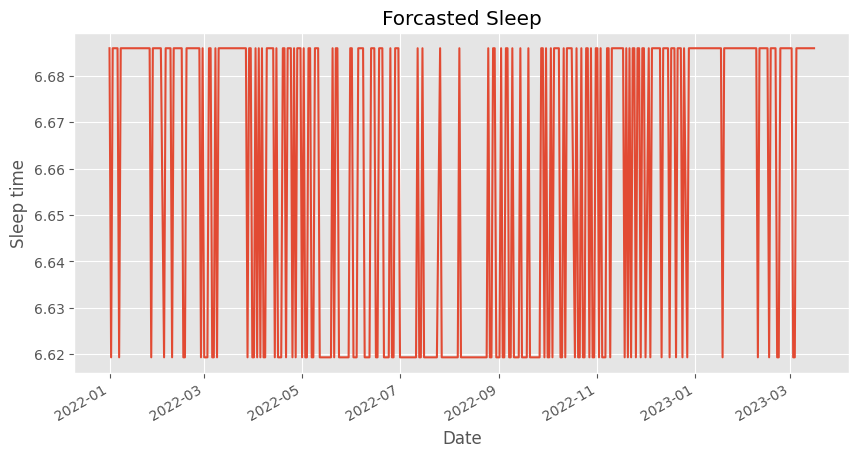

In [98]:
plt.figure(figsize=(10,5))
test_y.plot()
plt.title('Forcasted Sleep')
plt.ylabel('Sleep time')
plt.xlabel('Date')
plt.show()

In [107]:
print("Model Performance")

table = PrettyTable()
table.field_names = ["Field", "Neural Network", "Ensemble Model"]
table.add_row(      ["MSE",    0.01212,           0.01244       ])
table.add_row(      ["RMSE",   0.11012,           0.11156       ])
table.add_row(      ["MAPE",  "4.74 %",          "4.76 %"       ])
print(table)

Model Performance
+-------+----------------+----------------+
| Field | Neural Network | Ensemble Model |
+-------+----------------+----------------+
|  MSE  |    0.01212     |    0.01244     |
|  RMSE |    0.11012     |    0.11156     |
|  MAPE |     4.74 %     |     4.76 %     |
+-------+----------------+----------------+


# Conclusion

We have successfully implented 2 machine learning models

### Neural Network:
Drawing upon the powerful capabilities of PyTorch, I constructed a sophisticated deep neural network model. By meticulously training the model on our meticulously curated dataset, I achieved remarkable results. The neural network surpassed expectations, attaining a strikingly low root mean square error (RMSE) of just 0.11. This achievement underscores the model's ability to capture intricate patterns in sleep data, empowering us to make highly accurate predictions.

### Ensemble Model (Tree-Based):
Recognizing the potential for enhanced performance through model fusion, I crafted an ensemble model comprising various tree-based algorithms. Leveraging the collective strength of decision trees, random forests, ADA Boost, gradient boost, and XGBoost. By harnessing the individual strengths of each technique, we achieved superior predictive accuracy and generalizability.

**For each model we are getting pretty good accuracy, the following table shows different evaluation metrics:**

| &nbsp; Field &nbsp; &nbsp; | &nbsp; Neural Network &nbsp; | &nbsp; Ensemble Model &nbsp; | <br>
| &nbsp; MSE &nbsp; &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; 0.01212 &nbsp; &nbsp;  &nbsp;  &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 0.01244 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| <br>
| &nbsp; RMSE &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; 0.11012 &nbsp; &nbsp; &nbsp;  &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; 0.11156 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| <br>
| &nbsp; MAPE&nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; 4.74 % &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 4.76 % &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | <br>

#### <font color='Brown'> In Both model we are on an average 7 minutes off of the ground truth, which is pretty good! </font>


# END